# **242A Final Project Master Code**

### Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

### Upload CSV

In [ ]:
df = pd.read_csv("spotify_dataset.csv")
df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

### Data Preprocessing Pt.1 (Data Cleaning)

In [ ]:
# Drop missing values
df = df.dropna()
print(f"After dropping NA: {len(df)} rows")

# Remove duplicate rows
print("Number of duplicate records: ", len(df[df.duplicated()]))
df = df[~df.duplicated()]
print("After removing duplicates: ", len(df))
df[['explicit','mode']] = df[['explicit','mode']].astype(int)

# Check for tracks with multiple rows
track_counts = df['track_id'].value_counts()
multiple_tracks = track_counts[track_counts > 1]


if not multiple_tracks.empty:
    print("Tracks with multiple rows:")
    print(multiple_tracks.head())
else:
    print("No tracks have multiple rows.")

# Function to handle mode aggregation for string columns
def mode_as_string(series):
    unique_modes = series.mode().astype(str).unique()
    return ', '.join(unique_modes)

# Aggregate duplicate tracks by track_id
aggregated = df.groupby(['track_id']).agg({
    'track_name': pd.Series.mode,
    'artists': mode_as_string,
    'album_name': pd.Series.mode,
    'explicit': 'max',
    'track_genre': mode_as_string,
    'time_signature': 'max',
    'key': 'max',
    'mode': 'max',
    'popularity': 'mean',
    'duration_ms': 'mean',
    'danceability': 'mean',
    'energy': 'mean',
    'loudness': 'mean',
    'speechiness': 'mean',
    'acousticness': 'mean',
    'instrumentalness': 'mean',
    'valence': 'mean',
    'tempo': 'mean',
    'liveness': 'mean'
}).reset_index()

df = aggregated.copy()

# Verify no more duplicate tracks
track_counts = df['track_id'].value_counts()
multiple_tracks = track_counts[track_counts > 1]

if not multiple_tracks.empty:
    print("Tracks with multiple rows after aggregation:")
    print(multiple_tracks)
else:
    print("No tracks have multiple rows.")

print(f"Final dataset shape: {df.shape}")

After dropping NA: 113999 rows
Number of duplicate records:  0
After removing duplicates:  113999
Tracks with multiple rows:
track_id
6S3JlDAGk3uu3NtZbPnuhS    9
2Ey6v4Sekh3Z0RUSISRosD    8
2kkvB3RNRzwjFdGhaUA0tz    8
08kTa3SL9sV6Iy8KLKtGql    7
4XYieGKSlJlHpzB3bl6WMP    7
Name: count, dtype: int64
No tracks have multiple rows.
Final dataset shape: (89740, 20)


### Data Preprocessing Pt.2 (Target Variable and Feature Selection)

In [ ]:
# Select target variable
df["is_popular"] = (df["popularity"] >= df["popularity"].quantile(0.9)).astype(int)

# Drop irrelevant columns
drop_cols = [
    "Unnamed: 0", "track_id",
    "album_name", "track_name", "popularity"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Convert boolean to int
if "explicit" in df.columns:
    df["explicit"] = df["explicit"].astype(int)

# Define X and y
X = df.drop(columns=["is_popular"])
y = df["is_popular"]

# Define feature groups
num_features = [
    "duration_ms","danceability","energy","loudness","speechiness",
    "acousticness","instrumentalness","liveness","valence","tempo"
]
cat_features = ["key","mode","time_signature","explicit","track_genre"]

# Keep only features that actually exist in X
num_features = [f for f in num_features if f in X.columns]
cat_features = [f for f in cat_features if f in X.columns]

# Encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), cat_features)
    ],
    remainder="drop"
)


# Extract genres for dashboard mapping
preprocessor.fit(X)
genre_index = cat_features.index("track_genre")
track_genres = preprocessor.named_transformers_["cat"].categories_[genre_index]
track_genre_mapping = pd.DataFrame({
    "genre": track_genres,
    "encoding": range(len(track_genres))
})
print(track_genre_mapping)

# Define LASSO (L1) logistic regression pipeline
lasso_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        penalty="l1", solver="liblinear", C=1.0, max_iter=1000))
])

print("Data ready. X shape:", X.shape)
print("Numeric features:", num_features)
print("Categorical features:", cat_features)
print(df.head())

                              genre  encoding
0                          acoustic         0
1                   acoustic, blues         1
2            acoustic, blues, j-pop         2
3     acoustic, blues, j-rock, jazz         3
4                 acoustic, british         4
...                             ...       ...
1424               techno, trip-hop      1424
1425                         trance      1425
1426                       trip-hop      1426
1427                        turkish      1427
1428                    world-music      1428

[1429 rows x 2 columns]
Data ready. X shape: (89740, 16)
Numeric features: ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
Categorical features: ['key', 'mode', 'time_signature', 'explicit', 'track_genre']
                    artists  explicit     track_genre  time_signature  key  \
0                      Rill         1          german               4    8

### Data Preprocessing Pt.3 (Train/Test Split)

In [ ]:
# 80% train, 20% test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### LASSO Model

In [ ]:
# Fit the pipeline
lasso_pipeline.fit(X_train, y_train)

# Get feature names and coefficients
feature_names = num_features + cat_features
coef = lasso_pipeline.named_steps["classifier"].coef_[0]
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})

# Keep only nonzero coefficients
selected_features = coef_df[coef_df["Coefficient"] != 0].copy()
selected_features["AbsCoef"] = selected_features["Coefficient"].abs()
selected_features = selected_features.sort_values(by="AbsCoef", ascending=False)

print(f"Number of selected features: {len(selected_features)}")
print(selected_features.head(15))

Number of selected features: 15
             Feature  Coefficient   AbsCoef
13          explicit     0.481592  0.481592
6   instrumentalness    -0.460073  0.460073
5       acousticness    -0.296156  0.296156
7           liveness    -0.217497  0.217497
2             energy    -0.206701  0.206701
4        speechiness    -0.183426  0.183426
0        duration_ms    -0.161953  0.161953
11              mode    -0.141174  0.141174
1       danceability     0.126792  0.126792
8            valence    -0.084706  0.084706
9              tempo    -0.079894  0.079894
3           loudness     0.043256  0.043256
12    time_signature    -0.030548  0.030548
10               key    -0.000919  0.000919
14       track_genre    -0.000146  0.000146


### LASSO Model Evaluation

In [ ]:
y_pred = lasso_pipeline.predict(X_test)
y_prob = lasso_pipeline.predict_proba(X_test)[:, 1]

print("Train Accuracy:", lasso_pipeline.score(X_train, y_train))
print("Test Accuracy:", lasso_pipeline.score(X_test, y_test))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Train Accuracy: 0.8908234900824604
Test Accuracy: 0.8908513483396479
ROC-AUC: 0.6513970921368829

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     15989
           1       0.00      0.00      0.00      1959

    accuracy                           0.89     17948
   macro avg       0.45      0.50      0.47     17948
weighted avg       0.79      0.89      0.84     17948



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# ***PCA for Tree Models***

### Encode Categorical Variables

In [ ]:
label_cols = ["key", "mode", "time_signature", "track_genre"]
for col in label_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

### Data Preparation and Standardization

In [ ]:
X = df.drop(columns=["is_popular"])
y = df["is_popular"]
X = X.select_dtypes(include=["number"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardize numeric data (important before PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Principal Component Extraction

In [ ]:
pca = PCA()
pca.fit(X_train_scaled)

explained_var = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance:", explained_var)

# Choose number of components to keep 95% variance
n_components = np.argmax(explained_var >= 0.95) + 1
print(f"Keeping {n_components} components to explain 95% variance.")

# Apply PCA with chosen n_components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Cumulative explained variance: [0.20054913 0.30370326 0.3982086  0.47726262 0.54548186 0.61218592
 0.67513633 0.73505422 0.79282912 0.84920437 0.89988706 0.93950809
 0.96901417 0.99071813 1.        ]
Keeping 13 components to explain 95% variance.


### Component Loading Analysis

In [ ]:
pca_components = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print(pca_components.head())

     explicit  track_genre  time_signature       key      mode  duration_ms  \
PC1 -0.124311     0.013898       -0.200771 -0.005945  0.049436     0.009137   
PC2 -0.194252    -0.063292       -0.034557  0.009778 -0.098977     0.395967   
PC3  0.473815    -0.095618       -0.181103 -0.015983 -0.042423    -0.033816   
PC4  0.310623    -0.447450        0.269246 -0.068721 -0.374764     0.189970   
PC5 -0.048391     0.545890        0.025570  0.361355 -0.684824     0.094474   

     danceability    energy  loudness  speechiness  acousticness  \
PC1     -0.263165 -0.487472 -0.496537    -0.109599      0.420118   
PC2     -0.423881  0.273591  0.098728    -0.217846     -0.352671   
PC3     -0.232306  0.084780 -0.028377     0.608658      0.031848   
PC4      0.323862 -0.062451 -0.116682     0.155944     -0.095124   
PC5      0.072332  0.009543 -0.019018    -0.009072      0.004241   

     instrumentalness   valence     tempo  liveness  
PC1          0.272031 -0.288939 -0.190070 -0.076967  
PC2     

# ***CART (PCA)***

In [ ]:
# CV and Tuning Configuration
param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
base_cart = DecisionTreeClassifier(random_state=42)
cv = 5
scoring = "roc_auc"

# Fit CART on PCA-transformed data
grid_pca = GridSearchCV(base_cart, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
grid_pca.fit(X_train_pca, y_train)
best_cart_pca = grid_pca.best_estimator_

# Predictions
yprob_pca_train = best_cart_pca.predict_proba(X_train_pca)[:, 1]
yprob_pca_test  = best_cart_pca.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, yprob_pca_train)
best_thresh = thresholds[np.argmax(tpr - fpr)]
ypred_pca_train = (yprob_pca_train >= best_thresh).astype(int)
ypred_pca_test  = (yprob_pca_test  >= best_thresh).astype(int)
print("Best threshold (PCA):", best_thresh)

# Metrics
mse_pca_train = mean_squared_error(y_train, yprob_pca_train)
mse_pca_test  = mean_squared_error(y_test,  yprob_pca_test)
r2_pca_train  = r2_score(y_train, yprob_pca_train)
r2_pca_test   = r2_score(y_test,  yprob_pca_test)
acc_pca_train = accuracy_score(y_train, ypred_pca_train)
acc_pca_test  = accuracy_score(y_test,  ypred_pca_test)
auc_pca_train = roc_auc_score(y_train, yprob_pca_train)
auc_pca_test  = roc_auc_score(y_test,  yprob_pca_test)
ybar_train    = np.mean(y_train)
ss_res_pca    = np.sum((y_test - yprob_pca_test)**2)
ss_tot        = np.sum((y_test - ybar_train)**2)
osr2_pca      = 1 - ss_res_pca/ss_tot
cm_pca        = confusion_matrix(y_test, ypred_pca_test)

print("=== CART (PCA) ===")
print("Best params:", grid_pca.best_params_, "| CV AUC:", round(grid_pca.best_score_, 4))
print(f"Train Acc: {acc_pca_train:.4f} | Test Acc: {acc_pca_test:.4f}")
print(f"Train AUC: {auc_pca_train:.4f} | Test AUC: {auc_pca_test:.4f}")
print(f"Train MSE: {mse_pca_train:.4f} | R²: {r2_pca_train:.4f}")
print(f"Test  MSE: {mse_pca_test:.4f}  | R²: {r2_pca_test:.4f} | OSR²: {osr2_pca:.4f}")
print("Confusion Matrix (PCA):\n", cm_pca)



Best threshold (PCA): 0.1111111111111111
=== CART (PCA) ===
Best params: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10} | CV AUC: 0.6596
Train Acc: 0.5582 | Test Acc: 0.5461
Train AUC: 0.6884 | Test AUC: 0.6566
Train MSE: 0.0924 | R²: 0.0504
Test  MSE: 0.0949  | R²: 0.0237 | OSR²: 0.0237
Confusion Matrix (PCA):
 [[8416 7573]
 [ 573 1386]]


# ***CART (LASSO)***

In [ ]:
# CV and Tuning Configuration
param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
base_cart = DecisionTreeClassifier(random_state=42)
cv = 5
scoring = "roc_auc"

# Fit CART on LASSO-transformed data
Xtr_sel = X_train[selected_features]
Xte_sel = X_test[selected_features]

grid_lasso = GridSearchCV(base_cart, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
grid_lasso.fit(Xtr_sel, y_train)
best_cart_lasso = grid_lasso.best_estimator_

# Predictions
yprob_lasso_train = best_cart_lasso.predict_proba(Xtr_sel)[:, 1]
yprob_lasso_test  = best_cart_lasso.predict_proba(Xte_sel)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, yprob_lasso_train)
best_thresh = thresholds[np.argmax(tpr - fpr)]
ypred_lasso_train = (yprob_lasso_train >= best_thresh).astype(int)
ypred_lasso_test  = (yprob_lasso_test  >= best_thresh).astype(int)
print("Best threshold (LASSO):", best_thresh)

# Metrics
mse_lasso_train = mean_squared_error(y_train, yprob_lasso_train)
mse_lasso_test  = mean_squared_error(y_test,  yprob_lasso_test)
r2_lasso_train  = r2_score(y_train, yprob_lasso_train)
r2_lasso_test   = r2_score(y_test,  yprob_lasso_test)
acc_lasso_train = accuracy_score(y_train, ypred_lasso_train)
acc_lasso_test  = accuracy_score(y_test,  ypred_lasso_test)
auc_lasso_train = roc_auc_score(y_train, yprob_lasso_train)
auc_lasso_test  = roc_auc_score(y_test,  yprob_lasso_test)
ss_res_lasso    = np.sum((y_test - yprob_lasso_test)**2)
osr2_lasso      = 1 - ss_res_lasso/ss_tot
cm_lasso        = confusion_matrix(y_test, ypred_lasso_test)

print("\n=== CART (LASSO-selected features) ===")
print("Best params:", grid_lasso.best_params_, "| CV AUC:", round(grid_lasso.best_score_, 4))
print(f"Train Acc: {acc_lasso_train:.4f} | Test Acc: {acc_lasso_test:.4f}")
print(f"Train AUC: {auc_lasso_train:.4f} | Test AUC: {auc_lasso_test:.4f}")
print(f"Train MSE: {mse_lasso_train:.4f} | R²: {r2_lasso_train:.4f}")
print(f"Test  MSE: {mse_lasso_test:.4f}  | R²: {r2_lasso_test:.4f} | OSR²: {osr2_lasso:.4f}")
print("Confusion Matrix (LASSO):\n", cm_lasso)

Best threshold (LASSO): inf

=== CART (LASSO-selected features) ===
Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2} | CV AUC: 0.5
Train Acc: 0.8908 | Test Acc: 0.8909
Train AUC: 0.5000 | Test AUC: 0.5000
Train MSE: 0.0973 | R²: 0.0000
Test  MSE: 0.0972  | R²: -0.0000 | OSR²: 0.0000
Confusion Matrix (LASSO):
 [[15989     0]
 [ 1959     0]]


### CART (LASSO and PCA) Summary


=== Comparison (Test Set) ===
          Model  Test Accuracy  Test AUC       Test R²    OSR²  Test MSE
0    CART + PCA       0.546133  0.656598  2.370023e-02  0.0237  0.094931
1  CART + LASSO       0.890851  0.500000 -7.981495e-09  0.0000  0.097235


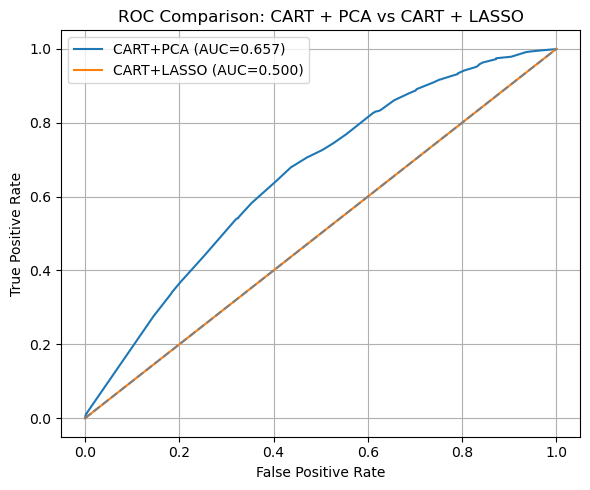

In [ ]:
summary = pd.DataFrame([
    ["CART + PCA",   acc_pca_test,   auc_pca_test,   r2_pca_test,   osr2_pca,   mse_pca_test],
    ["CART + LASSO", acc_lasso_test, auc_lasso_test, r2_lasso_test, osr2_lasso, mse_lasso_test],
], columns=["Model", "Test Accuracy", "Test AUC", "Test R²", "OSR²", "Test MSE"])
print("\n=== Comparison (Test Set) ===")
print(summary)

# ROC Curves
fpr_pca, tpr_pca, _ = roc_curve(y_test, yprob_pca_test)
fpr_las, tpr_las, _ = roc_curve(y_test, yprob_lasso_test)

plt.figure(figsize=(6,5))
plt.plot(fpr_pca, tpr_pca, label=f"CART+PCA (AUC={auc_pca_test:.3f})")
plt.plot(fpr_las, tpr_las, label=f"CART+LASSO (AUC={auc_lasso_test:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison: CART + PCA vs CART + LASSO")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ***Random Forest (LASSO)***

### Model Building

In [ ]:
# Random Forest pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

# Fit
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("RF Train Accuracy:", rf_pipeline.score(X_train, y_train))
print("RF Test Accuracy:", rf_pipeline.score(X_test, y_test))
print("RF ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("\nRF Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nRF Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

RF Train Accuracy: 0.9894277913973701
RF Test Accuracy: 0.8933585914865166
RF ROC-AUC: 0.8123312412556731

RF Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     15989
           1       0.53      0.19      0.28      1959

    accuracy                           0.89     17948
   macro avg       0.72      0.59      0.61     17948
weighted avg       0.87      0.89      0.87     17948


RF Confusion Matrix:
 [[15656   333]
 [ 1581   378]]


### Random Forest Feature Importance

track_genre         0.146936
duration_ms         0.087703
loudness            0.086236
instrumentalness    0.085302
acousticness        0.084646
energy              0.081252
liveness            0.080079
valence             0.076941
danceability        0.073353
speechiness         0.072419
tempo               0.069993
key                 0.035201
mode                0.008549
explicit            0.007241
time_signature      0.004149
dtype: float64


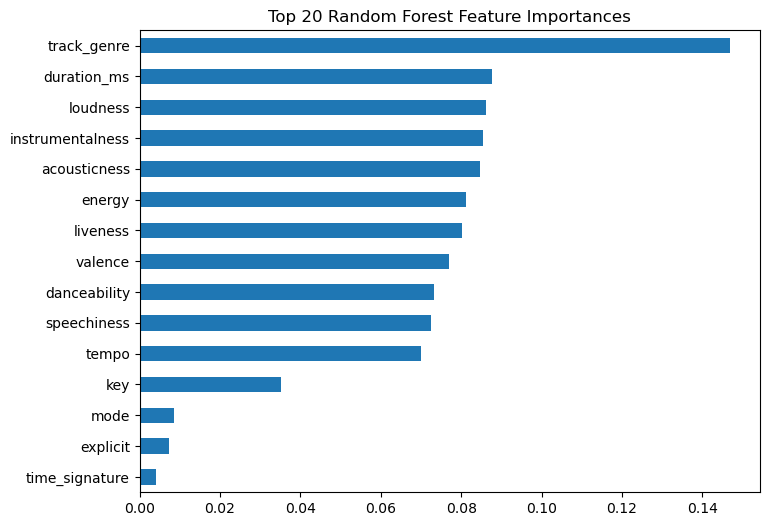

In [ ]:
# Get feature names after preprocessing
ohe = rf_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
feature_names = num_features + list(ohe.get_feature_names_out(cat_features))

rf_model = rf_pipeline.named_steps["classifier"]

importances = pd.Series(
    rf_model.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print(importances.head(20))

importances.head(20).sort_values().plot(
    kind="barh",
    figsize=(8,6),
    title="Top 20 Random Forest Feature Importances"
)
plt.show()

# ***Random Forest (PCA)***

In [ ]:
# Initialize Random Forest
rf_pca = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Fit on PCA features
rf_pca.fit(X_train_pca, y_train)

# Predictions
y_pred_rf_pca = rf_pca.predict(X_test_pca)
y_prob_rf_pca = rf_pca.predict_proba(X_test_pca)[:, 1]

# Evaluation
print("RF (PCA) Train Accuracy:", rf_pca.score(X_train_pca, y_train))
print("RF (PCA) Test Accuracy:", rf_pca.score(X_test_pca, y_test))
print("RF (PCA) ROC-AUC:", roc_auc_score(y_test, y_prob_rf_pca))
print("\nRF (PCA) Classification Report:\n", classification_report(y_test, y_pred_rf_pca))
print("\nRF (PCA) Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_pca))


RF (PCA) Train Accuracy: 0.993202585246267
RF (PCA) Test Accuracy: 0.8844439491865389
RF (PCA) ROC-AUC: 0.7274929091596312

RF (PCA) Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     15989
           1       0.37      0.08      0.13      1959

    accuracy                           0.88     17948
   macro avg       0.63      0.53      0.54     17948
weighted avg       0.84      0.88      0.85     17948


RF (PCA) Confusion Matrix:
 [[15714   275]
 [ 1799   160]]


## Comparision: Random Forest (Lasso) vs Random Forest (PCA)

Model Comparison: Random Forest (Lasso) vs Random Forest (PCA)
PERFORMANCE METRICS
        Metric  RF-Lasso   RF-PCA  Difference Winner
Train Accuracy  0.989428 0.993203   -0.003775    PCA
 Test Accuracy  0.893359 0.884444    0.008915  Lasso
 Train ROC-AUC  0.997685 0.998521   -0.000836    Tie
  Test ROC-AUC  0.812331 0.727493    0.084838  Lasso
Test Precision  0.531646 0.367816    0.163829  Lasso
   Test Recall  0.192956 0.081674    0.111281  Lasso
 Test F1-Score  0.283146 0.133668    0.149479  Lasso


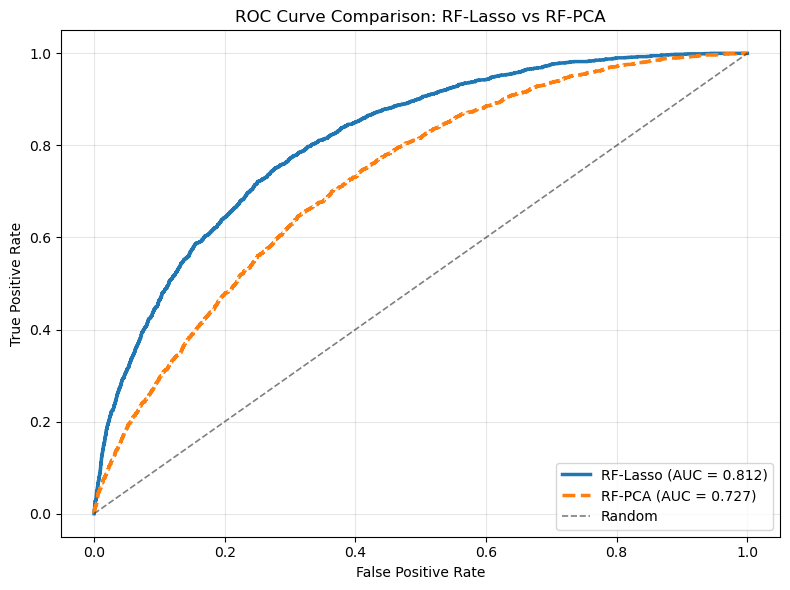

In [ ]:
print("Model Comparison: Random Forest (Lasso) vs Random Forest (PCA)")

# Lasso-features RF predictions
y_train_prob_rf_lasso = rf_pipeline.predict_proba(X_train)[:, 1]
y_test_prob_rf_lasso  = rf_pipeline.predict_proba(X_test)[:, 1]
y_train_class_rf_lasso = rf_pipeline.predict(X_train)
y_test_class_rf_lasso  = rf_pipeline.predict(X_test)

# PCA-features RF predictions
y_train_prob_rf_pca = rf_pca.predict_proba(X_train_pca)[:, 1]
y_test_prob_rf_pca  = rf_pca.predict_proba(X_test_pca)[:, 1]
y_train_class_rf_pca = rf_pca.predict(X_train_pca)
y_test_class_rf_pca  = rf_pca.predict(X_test_pca)

print("PERFORMANCE METRICS")

# RF-Lasso metrics
rf_lasso_train_acc = accuracy_score(y_train, y_train_class_rf_lasso)
rf_lasso_test_acc  = accuracy_score(y_test,  y_test_class_rf_lasso)
rf_lasso_train_auc = roc_auc_score(y_train, y_train_prob_rf_lasso)
rf_lasso_test_auc  = roc_auc_score(y_test,  y_test_prob_rf_lasso)
rf_lasso_precision = precision_score(y_test, y_test_class_rf_lasso)
rf_lasso_recall    = recall_score(y_test,  y_test_class_rf_lasso)
rf_lasso_f1        = f1_score(y_test,      y_test_class_rf_lasso)

# RF-PCA metrics
rf_pca_train_acc = accuracy_score(y_train, y_train_class_rf_pca)
rf_pca_test_acc  = accuracy_score(y_test,  y_test_class_rf_pca)
rf_pca_train_auc = roc_auc_score(y_train, y_train_prob_rf_pca)
rf_pca_test_auc  = roc_auc_score(y_test,  y_test_prob_rf_pca)
rf_pca_precision = precision_score(y_test, y_test_class_rf_pca)
rf_pca_recall    = recall_score(y_test,  y_test_class_rf_pca)
rf_pca_f1        = f1_score(y_test,      y_test_class_rf_pca)

comparison_data = {
    "Metric": [
        "Train Accuracy", "Test Accuracy", "Train ROC-AUC", "Test ROC-AUC",
        "Test Precision", "Test Recall", "Test F1-Score"
    ],
    "RF-Lasso": [
        rf_lasso_train_acc, rf_lasso_test_acc,
        rf_lasso_train_auc, rf_lasso_test_auc,
        rf_lasso_precision, rf_lasso_recall, rf_lasso_f1
    ],
    "RF-PCA": [
        rf_pca_train_acc, rf_pca_test_acc,
        rf_pca_train_auc, rf_pca_test_auc,
        rf_pca_precision, rf_pca_recall, rf_pca_f1
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Difference"] = comparison_df["RF-Lasso"] - comparison_df["RF-PCA"]
comparison_df["Winner"] = comparison_df["Difference"].apply(
    lambda x: "Lasso" if x > 0.001 else ("PCA" if x < -0.001 else "Tie")
)

print(comparison_df.to_string(index=False))

# ROC Curve Comparison Plot
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_test_prob_rf_lasso)
fpr_pca,   tpr_pca,   _ = roc_curve(y_test, y_test_prob_rf_pca)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lasso, tpr_lasso,
         label=f"RF-Lasso (AUC = {rf_lasso_test_auc:.3f})", linewidth=2.5)
plt.plot(fpr_pca, tpr_pca,
         label=f"RF-PCA (AUC = {rf_pca_test_auc:.3f})", linewidth=2.5, linestyle="--")
plt.plot([0, 1], [0, 1], "k--", label="Random", linewidth=1.2, alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: RF-Lasso vs RF-PCA")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# ***Boosting (LASSO)***


Top selected features by absolute coefficient:
         Feature  Coefficient
        explicit     0.481592
instrumentalness    -0.460073
    acousticness    -0.296156
        liveness    -0.217497
          energy    -0.206701
     speechiness    -0.183426
     duration_ms    -0.161953
            mode    -0.141174
    danceability     0.126792
         valence    -0.084706
           tempo    -0.079894
        loudness     0.043256
  time_signature    -0.030548
             key    -0.000919
     track_genre    -0.000146
Transformed shapes: Train=(71792, 15), Test=(17948, 15)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning:

[15:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Xgboost-LASSO Performance
Train Accuracy: 0.8914
Test Accuracy: 0.8912
Train ROC-AUC: 0.7752
Test ROC-AUC: 0.7134

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15989
           1       0.67      0.01      0.01      1959

    accuracy                           0.89     17948
   macro avg       0.78      0.50      0.48     17948
weighted avg       0.87      0.89      0.84     17948

Lasso Test Accuracy: 0.8909
Lasso Test AUC: 0.6393
Feature Importances

Top features by XGBoost importance:
         Feature  XGB_Importance  Coefficient  Abs_Lasso_Coefficient
instrumentalness        0.193092    -0.460073               0.460073
        loudness        0.115886     0.043256               0.043256
          energy        0.108752    -0.206701               0.206701
        liveness        0.108135    -0.217497               0.217497
    acousticness        0.107447    -0.296156               0.296156
  

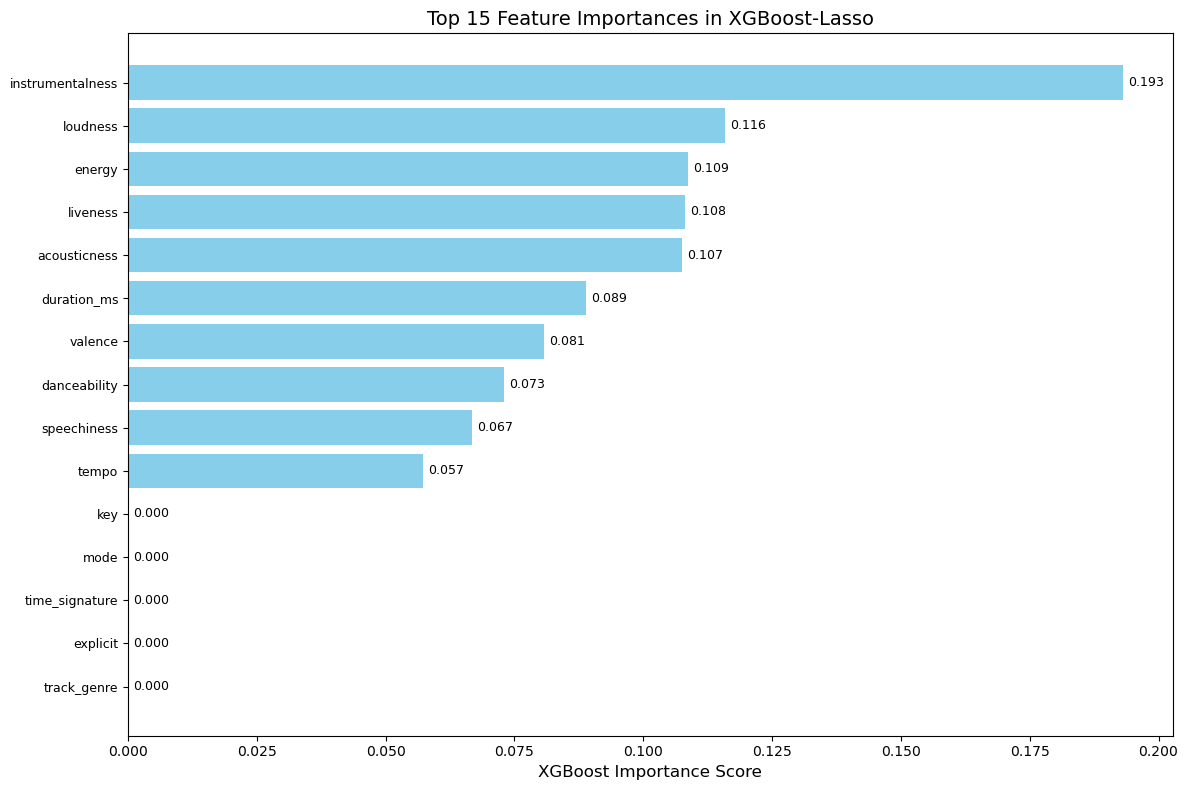

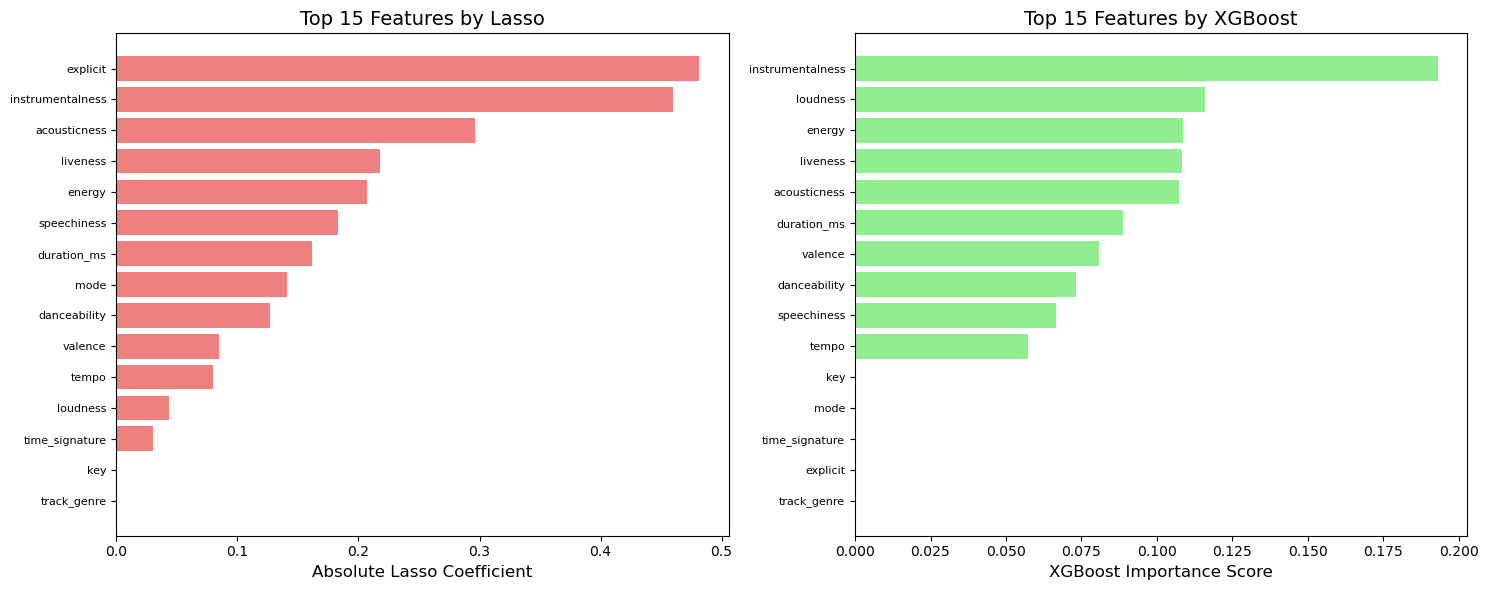

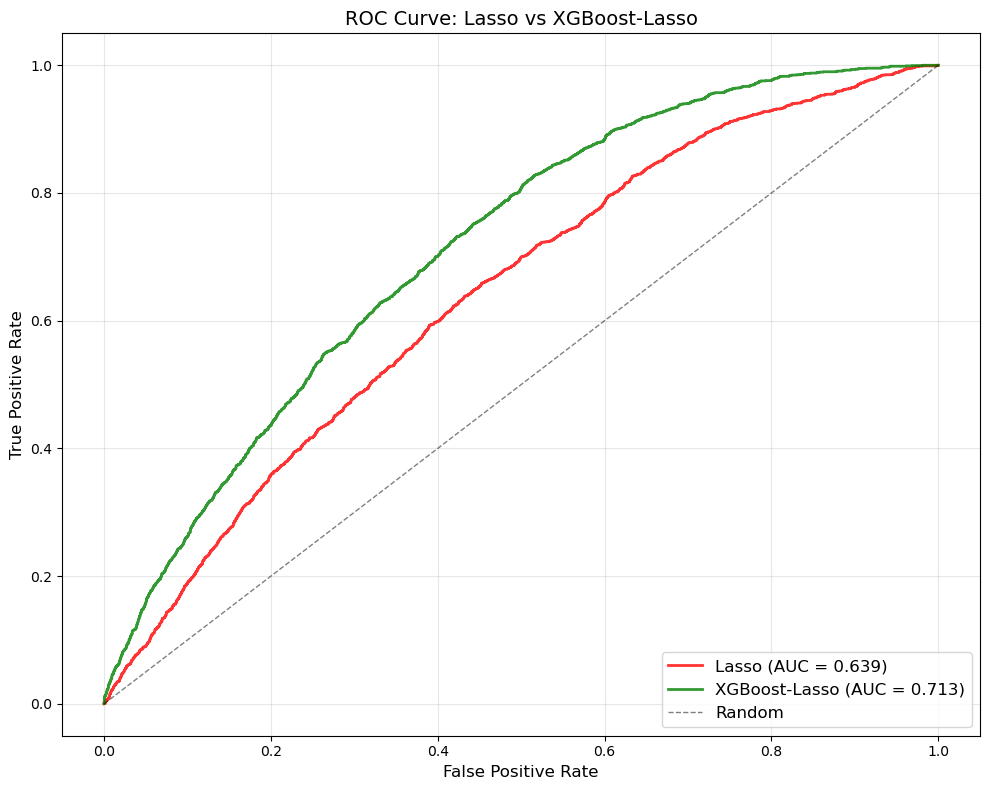

In [ ]:
### Feature Selection using Lasso Coefficients

# Copy original data to fix data types
X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()

# Convert categorical columns to strings and handle missing values
categorical_cols = ['key', 'mode', 'time_signature', 'explicit', 'track_genre']

for col in categorical_cols:
    if col in X_train_fixed.columns:
        # Convert to string and fill NaN with 'missing'
        X_train_fixed[col] = X_train_fixed[col].fillna('missing').astype(str)
        X_test_fixed[col] = X_test_fixed[col].fillna('missing').astype(str)

# Get the classifier from the pipeline
lasso_classifier = lasso_pipeline.named_steps["classifier"]

# Get coefficients
coef = lasso_classifier.coef_[0]

# Get the preprocessor
preprocessor = lasso_pipeline.named_steps["preprocessor"]

# Get feature names from preprocessor
numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][2]
ohe = preprocessor.named_transformers_["cat"]

# Generate feature names
feature_names = []
feature_names.extend(numeric_features)

# Generate categorical feature names
if hasattr(ohe, 'get_feature_names_out'):
    cat_names = ohe.get_feature_names_out(categorical_features)
    feature_names.extend(cat_names)
else:
    # Fallback method
    for cat_idx, cat_feature in enumerate(categorical_features):
        categories = ohe.categories_[cat_idx]
        for category in categories[1:]:  # Skip first due to drop='first'
            feature_names.append(f"{cat_feature}_{category}")

# Create coefficient DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})

# Select non-zero coefficients
selected_mask = coef != 0
selected_features = [feature_names[i] for i in np.where(selected_mask)[0]]
selected_coef = coef[selected_mask]

selected_features_df = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": selected_coef
})
selected_features_df["AbsCoefficient"] = selected_features_df["Coefficient"].abs()

print(f"\nTop selected features by absolute coefficient:")
top20 = selected_features_df.sort_values("AbsCoefficient", ascending=False).head(20)
print(top20[["Feature", "Coefficient"]].to_string(index=False))


# Transform using the preprocessor with fixed data
X_train_transformed = preprocessor.transform(X_train_fixed)
X_test_transformed = preprocessor.transform(X_test_fixed)

# Convert to dense arrays if needed
if hasattr(X_train_transformed, 'toarray'):
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()

print(f"Transformed shapes: Train={X_train_transformed.shape}, Test={X_test_transformed.shape}")

# Create DataFrames
X_train_full = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_full = pd.DataFrame(X_test_transformed, columns=feature_names)

# Select only Lasso-selected features
X_train_lasso = X_train_full[selected_features]
X_test_lasso = X_test_full[selected_features]

# Initialize XGBoost classifier
xgb_lasso = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_lasso.fit(X_train_lasso, y_train)

# Update variable names for predictions
y_train_pred_lasso_xgb = xgb_lasso.predict_proba(X_train_lasso)[:, 1]
y_test_pred_lasso_xgb = xgb_lasso.predict_proba(X_test_lasso)[:, 1]
y_train_class_lasso_xgb = xgb_lasso.predict(X_train_lasso)
y_test_class_lasso_xgb = xgb_lasso.predict(X_test_lasso)

# Calculate metrics
train_acc_lasso_xgb = accuracy_score(y_train, y_train_class_lasso_xgb)
test_acc_lasso_xgb = accuracy_score(y_test, y_test_class_lasso_xgb)
train_auc_lasso_xgb = roc_auc_score(y_train, y_train_pred_lasso_xgb)
test_auc_lasso_xgb = roc_auc_score(y_test, y_test_pred_lasso_xgb)

print("Xgboost-LASSO Performance")
print(f"Train Accuracy: {train_acc_lasso_xgb:.4f}")
print(f"Test Accuracy: {test_acc_lasso_xgb:.4f}")
print(f"Train ROC-AUC: {train_auc_lasso_xgb:.4f}")
print(f"Test ROC-AUC: {test_auc_lasso_xgb:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_class_lasso_xgb))

# Use the fixed data for Lasso predictions too
y_pred_lasso = lasso_pipeline.predict(X_test_fixed)
y_prob_lasso = lasso_pipeline.predict_proba(X_test_fixed)[:, 1]

lasso_test_acc = accuracy_score(y_test, y_pred_lasso)
lasso_test_auc = roc_auc_score(y_test, y_prob_lasso)

print(f"Lasso Test Accuracy: {lasso_test_acc:.4f}")
print(f"Lasso Test AUC: {lasso_test_auc:.4f}")

print("Feature Importances")

# Get feature importance from XGBoost model
xgb_importance_scores = xgb_lasso.feature_importances_

# Create importance DataFrame
xgb_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'XGB_Importance': xgb_importance_scores
})

# Merge with Lasso coefficients
xgb_importance_df = xgb_importance_df.merge(
    selected_features_df[['Feature', 'Coefficient']],
    on='Feature'
)
xgb_importance_df['Abs_Lasso_Coefficient'] = xgb_importance_df['Coefficient'].abs()

# Sort by XGBoost importance
xgb_importance_df = xgb_importance_df.sort_values('XGB_Importance', ascending=False)

print("\nTop features by XGBoost importance:")
print(xgb_importance_df.head(20).to_string(index=False))

### Model Comparison

print("\nModel Comparison: Lasso vs XGBoost-Lasso")
print(f"{'Metric':<20} {'Lasso':<12} {'XGBoost':<12} {'Diff':<10}")
print(f"{'Test Accuracy':<20} {lasso_test_acc:<12.4f} {test_acc_lasso_xgb:<12.4f} {test_acc_lasso_xgb - lasso_test_acc:+.4f}")
print(f"{'Test ROC-AUC':<20} {lasso_test_auc:<12.4f} {test_auc_lasso_xgb:<12.4f} {test_auc_lasso_xgb - lasso_test_auc:+.4f}")

### Visualizations

# Plot 1: Top 20 XGBoost Feature Importances
plt.figure(figsize=(12, 8))
top_n = min(20, len(xgb_importance_df))
top_features = xgb_importance_df.head(top_n)

y_pos = np.arange(top_n)
plt.barh(y_pos, top_features['XGB_Importance'][::-1], color='skyblue')
plt.yticks(y_pos, top_features['Feature'][::-1], fontsize=9)
plt.xlabel('XGBoost Importance Score', fontsize=12)
plt.title(f'Top {top_n} Feature Importances in XGBoost-Lasso', fontsize=14)

# Add value labels
for i, v in enumerate(top_features['XGB_Importance'][::-1]):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Plot 2: Feature Importance Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Lasso coefficients
top_lasso = selected_features_df.sort_values('AbsCoefficient', ascending=False).head(15)
axes[0].barh(range(len(top_lasso)), top_lasso['AbsCoefficient'][::-1], color='lightcoral')
axes[0].set_yticks(range(len(top_lasso)))
axes[0].set_yticklabels(top_lasso['Feature'][::-1], fontsize=8)
axes[0].set_xlabel('Absolute Lasso Coefficient', fontsize=12)
axes[0].set_title('Top 15 Features by Lasso', fontsize=14)

# XGBoost importance
top_xgb = xgb_importance_df.head(15)
axes[1].barh(range(len(top_xgb)), top_xgb['XGB_Importance'][::-1], color='lightgreen')
axes[1].set_yticks(range(len(top_xgb)))
axes[1].set_yticklabels(top_xgb['Feature'][::-1], fontsize=8)
axes[1].set_xlabel('XGBoost Importance Score', fontsize=12)
axes[1].set_title('Top 15 Features by XGBoost', fontsize=14)

plt.tight_layout()
plt.show()

# Plot 3: ROC Curve Comparison
from sklearn.metrics import roc_curve

fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_prob_lasso)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_lasso_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lasso, tpr_lasso, label=f'Lasso (AUC = {lasso_test_auc:.3f})',
         linewidth=2, color='red', alpha=0.8)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost-Lasso (AUC = {test_auc_lasso_xgb:.3f})',
         linewidth=2, color='green', alpha=0.8)
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1, alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve: Lasso vs XGBoost-Lasso', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ***Boosting (PCA)***

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning:

[15:23:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Xgboost-PCA Model Evaluation
Train Accuracy: 0.8918
Test Accuracy: 0.8910
Train ROC-AUC: 0.8111
Test ROC-AUC: 0.7068

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15989
           1       0.56      0.00      0.01      1959

    accuracy                           0.89     17948
   macro avg       0.73      0.50      0.48     17948
weighted avg       0.86      0.89      0.84     17948

Confusion Matrix (Test Set):
[[15982     7]
 [ 1950     9]]

Feature Importances:
   Feature  Importance
10    PC11    0.112541
1      PC2    0.111789
0      PC1    0.107080
3      PC4    0.091714
8      PC9    0.084209
7      PC8    0.067125
6      PC7    0.065919
11    PC12    0.064612
2      PC3    0.064549
12    PC13    0.064361
Model Comparison: CART vs XGBoost-PCA
Metric          CART       XGBoost-PCA    
Test Accuracy   0.8165      0.8910
Test ROC-AUC    0.5429      0.7068


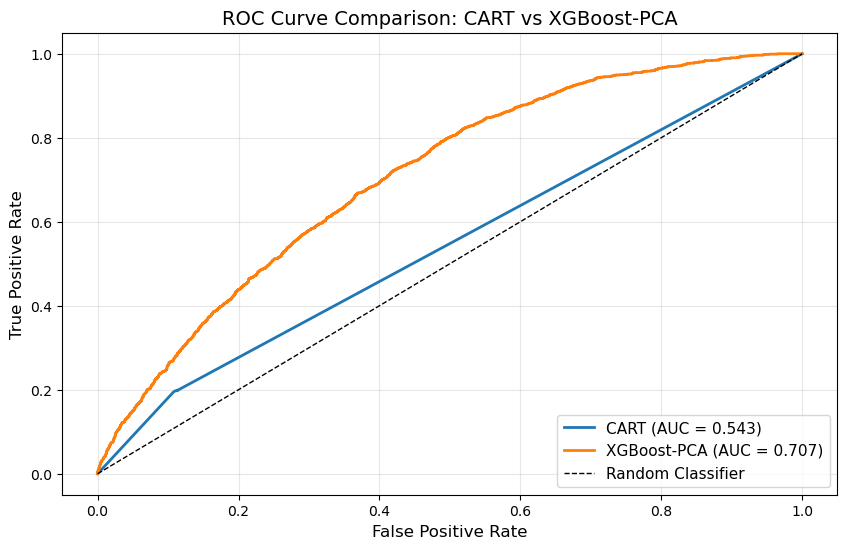

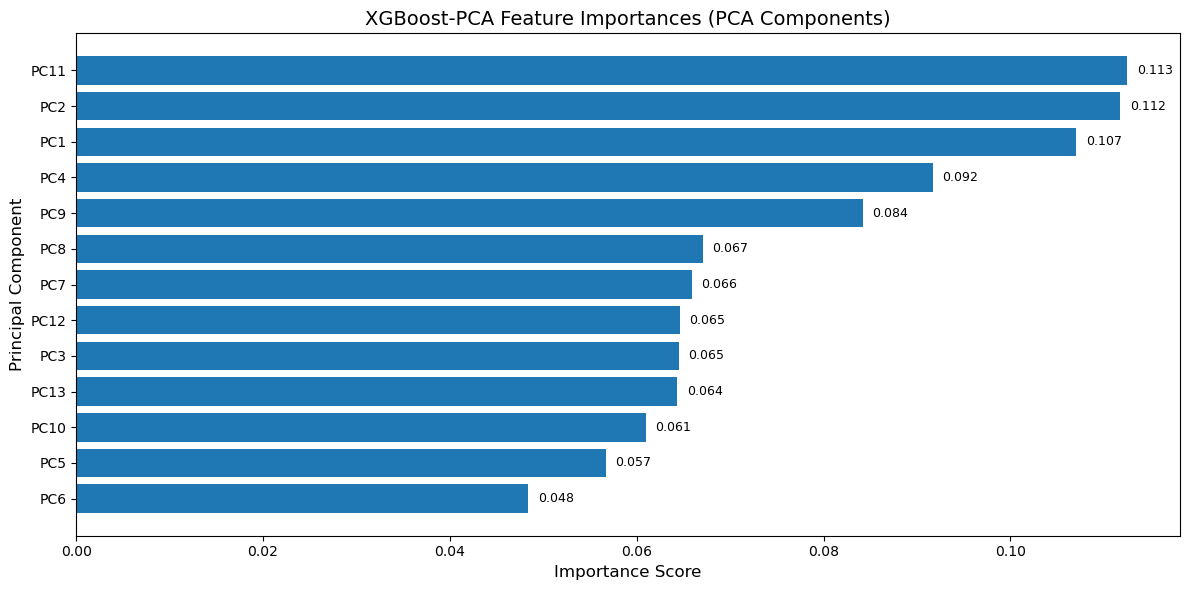

In [ ]:
### Boosting on PCA-Transformed Data

# Cart model on PCA-transformed data
cart = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,     # try tuning later
    min_samples_split=2,
    random_state=42
)

cart.fit(X_train_pca, y_train)

# Predict probabilities
y_train_pred_cart = cart.predict_proba(X_train_pca)[:, 1]
y_test_pred_cart = cart.predict_proba(X_test_pca)[:, 1]

# Initialize XGBoost classifier
xgb_pca = xgb.XGBClassifier(
    n_estimators=100,           # Number of boosting rounds
    learning_rate=0.1,          # Step size shrinkage
    max_depth=6,               # Maximum tree depth
    min_child_weight=1,        # Minimum sum of instance weight needed in a child
    subsample=0.8,             # Subsample ratio of training instances
    colsample_bytree=0.8,      # Subsample ratio of columns when constructing each tree
    random_state=42,
    use_label_encoder=False,   # Avoid warning
    eval_metric='logloss',     # Evaluation metric for binary classification
    n_jobs=-1
)

# Train the XGBoost model
xgb_pca.fit(X_train_pca, y_train)

# Update variable names for predictions
y_train_pred_pca_xgb = xgb_pca.predict_proba(X_train_pca)[:, 1]
y_test_pred_pca_xgb = xgb_pca.predict_proba(X_test_pca)[:, 1]
y_train_class_pca_xgb = xgb_pca.predict(X_train_pca)
y_test_class_pca_xgb = xgb_pca.predict(X_test_pca)

### Evaluate XGBoost-PCA Model

print("Xgboost-PCA Model Evaluation")

# Accuracy
train_acc_pca_xgb = accuracy_score(y_train, y_train_class_pca_xgb)
test_acc_pca_xgb = accuracy_score(y_test, y_test_class_pca_xgb)
print(f"Train Accuracy: {train_acc_pca_xgb:.4f}")
print(f"Test Accuracy: {test_acc_pca_xgb:.4f}")

# ROC-AUC
train_auc_pca_xgb = roc_auc_score(y_train, y_train_pred_pca_xgb)
test_auc_pca_xgb = roc_auc_score(y_test, y_test_pred_pca_xgb)
print(f"Train ROC-AUC: {train_auc_pca_xgb:.4f}")
print(f"Test ROC-AUC: {test_auc_pca_xgb:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_class_pca_xgb))

# Confusion Matrix
print("Confusion Matrix (Test Set):")
cm_xgb = confusion_matrix(y_test, y_test_class_pca_xgb)
print(cm_xgb)

# Feature Importance (from XGBoost's built-in importance)
print("\nFeature Importances:")
importance_scores = xgb_pca.feature_importances_
feature_names_pca = [f"PC{i+1}" for i in range(n_components)]
importance_df = pd.DataFrame({
    'Feature': feature_names_pca,
    'Importance': importance_scores
}).sort_values('Importance', ascending=False)

print(importance_df.head(10))

# CART predictions
y_test_class_cart = cart.predict(X_test_pca)

# CART metrics
cart_test_acc = accuracy_score(y_test, y_test_class_cart)
cart_test_auc = roc_auc_score(y_test, y_test_pred_cart)

print("Model Comparison: CART vs XGBoost-PCA")
print(f"{'Metric':<15} {'CART':<10} {'XGBoost-PCA':<15}")
print(f"{'Test Accuracy':<15} {cart_test_acc:.4f}      {test_acc_pca_xgb:.4f}")
print(f"{'Test ROC-AUC':<15} {cart_test_auc:.4f}      {test_auc_pca_xgb:.4f}")

### Visualizations
# Calculate ROC curves
fpr_cart, tpr_cart, _ = roc_curve(y_test, y_test_pred_cart)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_pca_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_cart, tpr_cart, label=f'CART (AUC = {cart_test_auc:.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost-PCA (AUC = {test_auc_pca_xgb:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: CART vs XGBoost-PCA', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Feature Importance Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Principal Component', fontsize=12)
plt.title('XGBoost-PCA Feature Importances (PCA Components)', fontsize=14)
plt.gca().invert_yaxis()  # Highest importance at top

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()


Model Comarison: XGBoost-Lasso vs XGBoost-PCA
Performance Metrics
        Metric  XGBoost-Lasso  XGBoost-PCA  Difference Winner
Train Accuracy       0.891436     0.891840   -0.000404    Tie
 Test Accuracy       0.891186     0.890963    0.000223    Tie
 Train ROC-AUC       0.775152     0.811110   -0.035958    PCA
  Test ROC-AUC       0.713373     0.706756    0.006617  Lasso
Test Precision       0.666667     0.562500    0.104167  Lasso
   Test Recall       0.006126     0.004594    0.001531  Lasso
 Test F1-Score       0.012140     0.009114    0.003026  Lasso


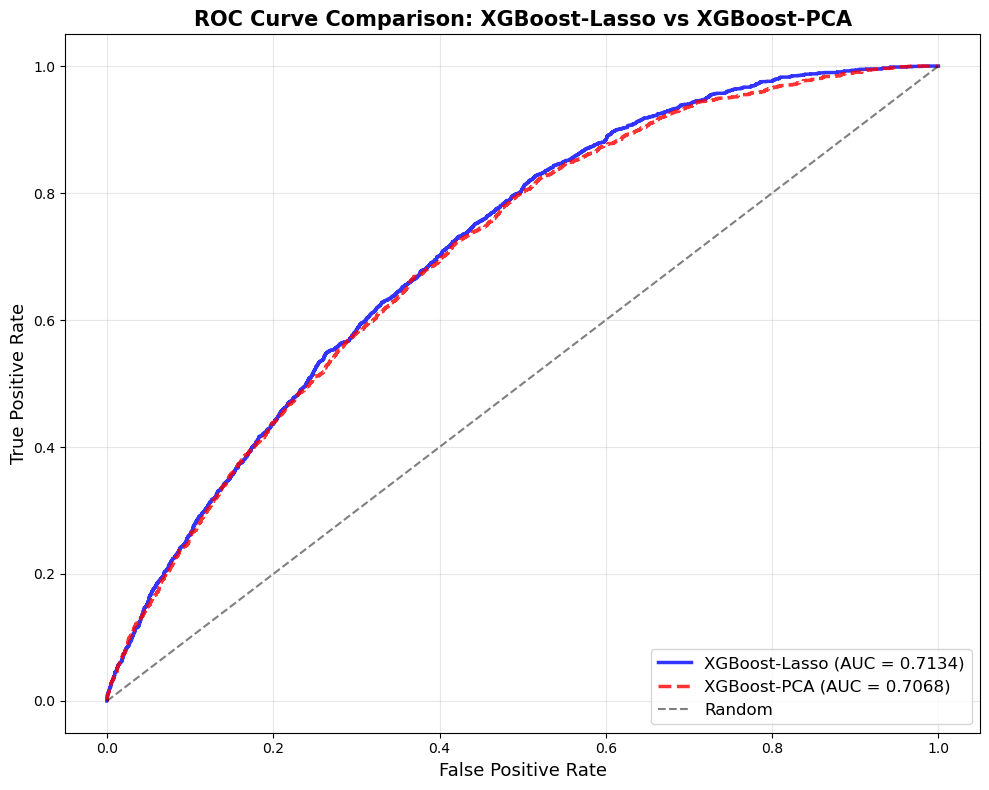

In [ ]:
### Model Comparison: XGBoost-Lasso vs XGBoost-PCA
print("Model Comarison: XGBoost-Lasso vs XGBoost-PCA")

print("Performance Metrics")
# XGBoost-Lasso metrics
xgb_lasso_train_acc = accuracy_score(y_train, y_train_class_lasso_xgb)
xgb_lasso_test_acc = accuracy_score(y_test, y_test_class_lasso_xgb)
xgb_lasso_train_auc = roc_auc_score(y_train, y_train_pred_lasso_xgb)
xgb_lasso_test_auc = roc_auc_score(y_test, y_test_pred_lasso_xgb)
xgb_lasso_precision = precision_score(y_test, y_test_class_lasso_xgb)
xgb_lasso_recall = recall_score(y_test, y_test_class_lasso_xgb)
xgb_lasso_f1 = f1_score(y_test, y_test_class_lasso_xgb)

# XGBoost-PCA metrics
xgb_pca_train_acc = accuracy_score(y_train, y_train_class_pca_xgb)
xgb_pca_test_acc = accuracy_score(y_test, y_test_class_pca_xgb)
xgb_pca_train_auc = roc_auc_score(y_train, y_train_pred_pca_xgb)
xgb_pca_test_auc = roc_auc_score(y_test, y_test_pred_pca_xgb)
xgb_pca_precision = precision_score(y_test, y_test_class_pca_xgb)
xgb_pca_recall = recall_score(y_test, y_test_class_pca_xgb)
xgb_pca_f1 = f1_score(y_test, y_test_class_pca_xgb)

# Create comparison table
comparison_data = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Train ROC-AUC', 'Test ROC-AUC',
               'Test Precision', 'Test Recall', 'Test F1-Score'],
    'XGBoost-Lasso': [xgb_lasso_train_acc, xgb_lasso_test_acc, xgb_lasso_train_auc,
                      xgb_lasso_test_auc, xgb_lasso_precision, xgb_lasso_recall, xgb_lasso_f1],
    'XGBoost-PCA': [xgb_pca_train_acc, xgb_pca_test_acc, xgb_pca_train_auc,
                    xgb_pca_test_auc, xgb_pca_precision, xgb_pca_recall, xgb_pca_f1]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['XGBoost-Lasso'] - comparison_df['XGBoost-PCA']
comparison_df['Winner'] = comparison_df['Difference'].apply(lambda x: 'Lasso' if x > 0.001 else ('PCA' if x < -0.001 else 'Tie'))

print(comparison_df.to_string(index=False))

### Visualizations

# Calculate ROC curves
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_test_pred_lasso_xgb)
fpr_pca, tpr_pca, _ = roc_curve(y_test, y_test_pred_pca_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lasso, tpr_lasso, label=f'XGBoost-Lasso (AUC = {xgb_lasso_test_auc:.4f})',
         linewidth=2.5, color='blue', alpha=0.8)
plt.plot(fpr_pca, tpr_pca, label=f'XGBoost-PCA (AUC = {xgb_pca_test_auc:.4f})',
         linewidth=2.5, color='red', alpha=0.8, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5, alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve Comparison: XGBoost-Lasso vs XGBoost-PCA', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ***Song Popularity Probability Predictor (User Interactive)***

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

### Encoding ###
# Fit LabelEncoder only for track_genre
le_genre = LabelEncoder()
le_genre.fit(df["track_genre"].astype(str))

def encode_input(song_dict, le_genre):
    """
    Convert track_genre string into its encoded integer using fitted LabelEncoder.
    If unseen, returns -1.
    """
    song_copy = song_dict.copy()
    if "track_genre" in song_copy:
        val = str(song_copy["track_genre"])
        if val in le_genre.classes_:
            song_copy["track_genre"] = le_genre.transform([val])[0]
        else:
            song_copy["track_genre"] = -1  # unseen category
    return pd.DataFrame([song_copy])

### Data Reformatting ###
def make_input(song_dict):
    return pd.DataFrame([song_dict])

### LASSO Predictions ###
def predict_lasso_score(song_dict, lasso_pipeline):
    X_input = make_input(song_dict)
    score = lasso_pipeline.predict_proba(X_input)[:,1][0]
    return score

# CART + LASSO
def predict_cart_lasso(song_dict, le_genre, cart_model):
    X_input = encode_input(song_dict, le_genre)
    score = cart_model.predict_proba(X_input)[:, 1][0]
    return score

# Random Forest + LASSO
def predict_rf_lasso(song_dict, le_genre, rf_model):
    X_input = encode_input(song_dict, le_genre)
    score = rf_model.predict_proba(X_input)[:, 1][0]
    return score

# XGBoost + LASSO
def predict_xgb_lasso(song_dict, le_genre, xgb_model):
    ordered_features = [
        'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'key', 'mode', 'time_signature', 'explicit', 'track_genre'
    ]
    X_input = encode_input(song_dict, le_genre)
    X_input = X_input[ordered_features]
    score = xgb_model.predict_proba(X_input)[:, 1][0]
    return score

### PCA Predictions ###
def predict_cart_pca(song_dict, le_genre, scaler, pca, cart_model):
    X_input = encode_input(song_dict, le_genre)
    X_scaled = scaler.transform(X_input)
    X_pca = pca.transform(X_scaled)
    score = cart_model.predict_proba(X_pca)[:, 1][0]
    return score

def predict_rf_pca(song_dict, le_genre, scaler, pca, rf_model):
    X_input = encode_input(song_dict, le_genre)
    X_scaled = scaler.transform(X_input)
    X_pca = pca.transform(X_scaled)
    score = rf_model.predict_proba(X_pca)[:, 1][0]
    return score

def predict_xgb_pca(song_dict, le_genre, scaler, pca, xgb_model):
    X_input = encode_input(song_dict, le_genre)
    X_scaled = scaler.transform(X_input)
    X_pca = pca.transform(X_scaled)
    score = xgb_model.predict_proba(X_pca)[:, 1][0]
    return score

# Example
song_params = {
    "explicit": 0,
    "track_genre": "acoustic",
    "time_signature": 4,     
    "key": 1,             
    "mode": 0,               
    "duration_ms": 230666,
    "danceability": 0.676,
    "energy": 0.461,
    "loudness": -6.746,
    "speechiness": 0.143,
    "acousticness": 0.0322,
    "instrumentalness": 0.0,
    "valence": 0.715,
    "tempo": 87.917,
    "liveness": 0.358,
}

print("LASSO Baseline Popularity Probability Prediction:", predict_lasso_score(song_params, lasso_pipeline))

print("\nLASSO Predictions:")
print("CART Popularity Probability Prediction:", predict_cart_lasso(song_params, le_genre, best_cart_lasso))
print("Random Forest Popularity Probability Prediction:", predict_rf_lasso(song_params, le_genre, rf_pipeline))
print("XGBoost Popularity Probability Prediction:", predict_xgb_lasso(song_params, le_genre, xgb_lasso))

print("\nPCA Predictions:")
print("CART Popularity Probability Prediction:", predict_cart_pca(song_params, le_genre, scaler, pca, best_cart_pca))
print("Random Forest Popularity Probability Prediction:", predict_rf_pca(song_params, le_genre, scaler, pca, rf_pca))
print("XGBoost Popularity Probability Prediction:", predict_xgb_pca(song_params, le_genre, scaler, pca, xgb_pca))

LASSO Baseline Popularity Probability Prediction: 0.16992037949428274

LASSO Predictions:
CART Popularity Probability Prediction: 0.10917650991753956
Random Forest Popularity Probability Prediction: 0.5869942127377885
XGBoost Popularity Probability Prediction: 0.015047286

PCA Predictions:
CART Popularity Probability Prediction: 0.11156854672704816
Random Forest Popularity Probability Prediction: 0.1731413908068367
XGBoost Popularity Probability Prediction: 0.094198145


# ***Popularity Predictor Dashboard***

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State

external_stylesheets = [
    {
        "href": "https://cdnjs.cloudflare.com/ajax/libs/semantic-ui/2.4.1/semantic.min.css",
        "rel": "stylesheet",
    }
]

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# Spotify color palette
SPOTIFY_GREEN = "#1DB954"
SPOTIFY_BLACK = "#191414"
SPOTIFY_GRAY = "#282828"

model_options = [
    {"label": "LASSO", "value": "lasso"},
    {"label": "CART + LASSO", "value": "cart_lasso"},
    {"label": "Random Forest + LASSO", "value": "rf_lasso"},
    {"label": "XG Boost + LASSO", "value": "xgb_lasso"},
    {"label": "CART + PCA", "value": "cart_pca"},
    {"label": "Random Forest + PCA", "value": "rf_pca"},
    {"label": "XG Boost + PCA", "value": "xgb_pca"},
]

app.layout = html.Div(
    style={"backgroundColor": SPOTIFY_BLACK, "color": "white", "padding": "30px"},
    children=[
        html.H1(
            "🎵 Song Popularity Prediction Dashboard 🎵",
            style={"color": SPOTIFY_GREEN, "textAlign": "center", "marginBottom": "40px"},
        ),

        # Input Section
        html.Div(
            style={
                "display": "grid",
                "gridTemplateColumns": "1fr 1fr",
                "gap": "30px",
                "marginBottom": "40px",
            },
            children=[
                    html.Div([
                        html.Label("Track Genre", style={"color": SPOTIFY_GREEN}),
                        html.Div("The genre of the track", style={"marginBottom": "5px"}),
                        dcc.Dropdown(
                            id="track_genre",
                            options=[
                                {"label": row["genre"], "value": row["encoding"]}
                                for _, row in track_genre_mapping.iterrows()
                            ],
                            value=track_genre_mapping.loc[
                                track_genre_mapping["genre"] == "rock", "encoding"
                            ].values[0],  # default to "rock"
                            searchable=True,
                            style={
                                "backgroundColor": "#C0C0C0",
                                "color": "black",        
                                "marginBottom": "20px"
                            },
                            className="spotify-dropdown"
                        ),
                    
                    html.Label("Explicit", style={"color": SPOTIFY_GREEN}),
                    html.Div("Whether the track contains explicit content", style={"marginBottom": "5px"}),
                    dcc.Dropdown(
                        options=[{"label": "No", "value": 0}, {"label": "Yes", "value": 1}],
                        id="explicit", value=0,
                        style={
                            "backgroundColor": "#C0C0C0",
                            "color": "black",     
                            "marginBottom": "20px"
                        },
                        className="spotify-dropdown"
                    ),

                    html.Label("Time Signature", style={"color": SPOTIFY_GREEN}),
                    html.Div("Ranges from 3 to 7 (3 = 3/4, 4 = 4/4, etc.)", style={"marginBottom": "5px"}),
                    dcc.Dropdown(
                        options=[{"label": str(i), "value": i} for i in range(3, 8)],
                        id="time_signature", value=4,
                        style={
                            "backgroundColor": "#C0C0C0",
                            "color": "black",       
                            "marginBottom": "20px"
                        },
                        className="spotify-dropdown"
                    ),

                    html.Label("Key", style={"color": SPOTIFY_GREEN}),
                    html.Div("Ranges from 0 to 11 (0 = C, 1 = C#, 2 = D, etc.)", style={"marginBottom": "5px"}),
                    dcc.Dropdown(
                        options=[{"label": str(i), "value": i} for i in range(0, 12)],
                        id="key", value=1,
                        style={
                            "backgroundColor": "#C0C0C0",
                            "color": "black",    
                            "marginBottom": "20px"
                        },
                        className="spotify-dropdown"
                    ),

                    html.Label("Mode", style={"color": SPOTIFY_GREEN}),
                    html.Div("Major Scale is 1, Minor Scale is 0", style={"marginBottom": "5px"}),
                    dcc.Dropdown(
                        options=[{"label": "Major", "value": 1}, {"label": "Minor", "value": 0}],
                        id="mode", value=0,
                        style={
                            "backgroundColor": "#C0C0C0",
                            "color": "black",      
                            "marginBottom": "20px"
                        },
                        className="spotify-dropdown"
                    ),
                ], style={"padding": "20px", "backgroundColor": SPOTIFY_GRAY, "borderRadius": "10px"}),

                html.Div([
                    html.Label("Duration", style={"color": SPOTIFY_GREEN}),
                    html.Div("Track length in minutes and seconds", style={"marginBottom": "5px"}),
                    html.Div([
                        html.Div([
                            dcc.Input(
                                id="duration_min", type="number", value=3, min=0, max=20, step=1,
                                style={"width": "80px", "backgroundColor": SPOTIFY_GRAY, "color": "white"}
                            ),
                            html.Label("Minutes", style={"color": SPOTIFY_GREEN, "marginRight": "5px"}),
                        ], style={"display": "flex", "alignItems": "center", "marginRight": "20px"}),

                        html.Div([
                            dcc.Input(
                                id="duration_sec", type="number", value=50, min=0, max=59, step=1,
                                style={"width": "80px", "backgroundColor": SPOTIFY_GRAY, "color": "white"}
                            ),
                            html.Label("Seconds", style={"color": SPOTIFY_GREEN, "marginRight": "5px"}),
                        ], style={"display": "flex", "alignItems": "center"}),
                    ], style={"display": "flex", "justifyContent": "flex-start", "marginBottom": "20px"}),

                    html.Label("Danceability", style={"color": SPOTIFY_GREEN}),
                    html.Div("How suitable a track is for dancing (0: least danceable, 1: most danceable)", style={"marginBottom": "5px"}),
                    html.Div([
                        dcc.Slider(
                            id="danceability", min=0, max=1, step=0.01, value=0.676,
                            marks={i/10: str(i/10) for i in range(0, 11)}, tooltip={"always_visible": True}
                        )
                    ], style={"marginBottom": "20px"}), 

                    html.Label("Energy", style={"color": SPOTIFY_GREEN}),
                    html.Div("Intensity of the track (0: least energetic, 1: most energetic)", style={"marginBottom": "5px"}),
                    html.Div([
                        dcc.Slider(
                            id="energy", min=0, max=1, step=0.01, value=0.461,
                            marks={i/10: str(i/10) for i in range(0, 11)}, tooltip={"always_visible": True}
                        )
                    ], style={"marginBottom": "20px"}),

                    html.Label("Loudness (dB)", style={"color": SPOTIFY_GREEN}),
                    html.Div("Overall loudness of a track in decibels", style={"marginBottom": "5px"}),
                    html.Div([
                        dcc.Slider(
                            id="loudness", min=-60, max=5, step=0.1, value=-6.746,
                            marks={-60 + i*6.5: str(round(-60 + i*6.5, 1)) for i in range(0, 11)},
                            tooltip={"always_visible": True}
                        )
                    ], style={"marginBottom": "20px"}), 
                ], style={"padding": "20px", "backgroundColor": SPOTIFY_GRAY, "borderRadius": "10px"}),
            ],
        ),

        # More Sliders
        html.Div(
            style={"display": "grid", "gridTemplateColumns": "1fr 1fr", "gap": "30px"},
            children=[
                html.Div([
                    html.Label("Speechiness", style={"color": SPOTIFY_GREEN}),
                    html.Div("How much speech is in a track (0: least speech, 1: most speech)", style={"marginBottom": "5px"}),
                    html.Div([
                        dcc.Slider(
                            id="speechiness", min=0, max=1, step=0.01, value=0.143,
                            marks={i/10: str(i/10) for i in range(0, 11)}, tooltip={"always_visible": True}
                        )
                    ], style={"marginBottom": "20px"}),  

                    html.Label("Acousticness", style={"color": SPOTIFY_GREEN}),
                    html.Div("Ranged measure of whether a track is acoustic (0: not acoustic, 1: acoustic)", style={"marginBottom": "5px"}),
                    html.Div([
                        dcc.Slider(
                            id="acousticness", min=0, max=1, step=0.01, value=0.0322,
                            marks={i/10: str(i/10) for i in range(0, 11)}, tooltip={"always_visible": True}
                        )
                    ], style={"marginBottom": "20px"}), 

                    html.Label("Instrumentalness", style={"color": SPOTIFY_GREEN}),
                    html.Div("How much of the track is instrumental (0: purely vocal, 1: purely instrumental)", style={"marginBottom": "5px"}),
                    html.Div([
                        dcc.Slider(
                            id="instrumentalness", min=0, max=1, step=0.01, value=0.0,
                            marks={i/10: str(i/10) for i in range(0, 11)}, tooltip={"always_visible": True}
                        )
                    ], style={"marginBottom": "20px"}),  
                ], style={"padding": "20px", "backgroundColor": SPOTIFY_GRAY, "borderRadius": "10px"}),

                html.Div([
                    html.Label("Valence", style={"color": SPOTIFY_GREEN}),
                    html.Div("Overall measure of a track's positivity (0: sad/depressed, 1: happy/cheerful)", style={"marginBottom": "5px"}),
                    html.Div([
                        dcc.Slider(
                            id="valence", min=0, max=1, step=0.01, value=0.715,
                            marks={i/10: str(i/10) for i in range(0, 11)}, tooltip={"always_visible": True}
                        )
                    ], style={"marginBottom": "20px"}),   

                    html.Label("Tempo (BPM)", style={"color": SPOTIFY_GREEN}),
                    html.Div("Overall tempo of a track in BPM", style={"marginBottom": "5px"}),
                    html.Div([
                        dcc.Slider(
                            id="tempo", min=30, max=250, step=1, value=87.917,
                            marks={30 + i*22: str(30 + i*22) for i in range(0, 11)}, tooltip={"always_visible": True}
                        )
                    ], style={"marginBottom": "20px"}), 

                    html.Label("Liveness", style={"color": SPOTIFY_GREEN}),
                    html.Div("Ranged measure of whether a track was performed live (0: not live, 1: live)", style={"marginBottom": "5px"}),
                    html.Div([
                        dcc.Slider(
                            id="liveness", min=0, max=1, step=0.01, value=0.358,
                            marks={i/10: str(i/10) for i in range(0, 11)}, tooltip={"always_visible": True}
                        )
                    ], style={"marginBottom": "20px"}),  
                ], style={"padding": "20px", "backgroundColor": SPOTIFY_GRAY, "borderRadius": "10px"}),
            ],
        ),

        html.Hr(style={"borderColor": SPOTIFY_GREEN}),

        # Model Selection
        html.Div([
            html.Label("Select Model", style={"color": SPOTIFY_GREEN}),
            dcc.Dropdown(
                options=model_options,
                id="model_choice",
                value="lasso",
                style={
                    "backgroundColor": "#C0C0C0",
                    "color": "black",    
                }
            ),
        ], style={"marginBottom": "30px"}),

        html.Button(
            "Predict Popularity",
            id="predict_button",
            n_clicks=0,
            style={
                "backgroundColor": SPOTIFY_GREEN,
                "color": "white",
                "fontWeight": "bold",
                "padding": "15px 30px",
                "borderRadius": "30px",
                "border": "none",
                "cursor": "pointer",
                "display": "block",
                "margin": "0 auto",
            },
        ),

        html.H2(id="prediction_output", style={"marginTop": "40px", "textAlign": "center", "color": SPOTIFY_GREEN}),
    ])

# Callback
@app.callback(
    Output("prediction_output", "children"),
    Input("predict_button", "n_clicks"),
    State("explicit", "value"),
    State("track_genre", "value"),
    State("time_signature", "value"),
    State("key", "value"),
    State("mode", "value"),
    State("duration_min", "value"),   # minutes
    State("duration_sec", "value"),   # seconds
    State("danceability", "value"),
    State("energy", "value"),
    State("loudness", "value"),
    State("speechiness", "value"),
    State("acousticness", "value"),
    State("instrumentalness", "value"),
    State("valence", "value"),
    State("tempo", "value"),
    State("liveness", "value"),
    State("model_choice", "value")
)
def update_prediction(n_clicks, explicit, track_genre, time_signature, key, mode,
                      duration_min, duration_sec, danceability, energy, loudness, speechiness,
                      acousticness, instrumentalness, valence, tempo, liveness,
                      model_choice):
    if n_clicks == 0:
        return ""

    # Convert minutes + seconds → milliseconds
    duration_ms = (duration_min * 60 + duration_sec) * 1000

    song_params = {
        "explicit": explicit,
        "track_genre": track_genre,
        "time_signature": time_signature,
        "key": key,
        "mode": mode,
        "duration_ms": duration_ms,
        "danceability": danceability,
        "energy": energy,
        "loudness": loudness,
        "speechiness": speechiness,
        "acousticness": acousticness,
        "instrumentalness": instrumentalness,
        "valence": valence,
        "tempo": tempo,
        "liveness": liveness,
    }

    # model selection logic unchanged...
    if model_choice == "lasso":
        score = predict_lasso_score(song_params, lasso_pipeline)
    elif model_choice == "cart_lasso":
        score = predict_cart_lasso(song_params, le_genre, best_cart_lasso)
    elif model_choice == "rf_lasso":
        score = predict_rf_lasso(song_params, le_genre, rf_pipeline)
    elif model_choice == "xgb_lasso":
        score = predict_xgb_lasso(song_params, le_genre, xgb_lasso)
    elif model_choice == "cart_pca":
        score = predict_cart_pca(song_params, le_genre, scaler, pca, best_cart_pca)
    elif model_choice == "rf_pca":
        score = predict_rf_pca(song_params, le_genre, scaler, pca, rf_pca)
    elif model_choice == "xgb_pca":
        score = predict_xgb_pca(song_params, le_genre, scaler, pca, xgb_pca)
    else:
        return "Invalid model choice."

    return f"Predicted Popularity Probability: {score:.4f}"

# Run App
if __name__ == "__main__":
    app.run(port=8051, debug=True)
# Run at http://127.0.0.1:8051/